##### Comparazione tra gradient boosting, random forest e vari modelli di reti neurali  
*Train set sul cromosoma 22, test sul cromosoma 21*

In [77]:
from fastai.tabular.all import *
from warnings import simplefilter
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
set_seed(42)
simplefilter(action="ignore", category=FutureWarning)

In [78]:
df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')
df = df.apply(lambda x: x.str.split(';') if x.dtype == "object" else x)
df = df.map(lambda x: x.remove('') if type(x) is list and '' in x else x)

l = []

for col in df.columns:
    if df[col].apply(lambda x: len(x) if type(x) is list else list()).equals(df['aapos'].apply(lambda x: len(x) if type(x) is list else list())):
        l.append(col)

l.append('TSL')
df = df.explode(l)
df = df.map(lambda x: x[0] if type(x) is list and len(x) == 1 else x)
df.replace(to_replace='.', value=np.nan, inplace=True)
df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
df.dropna(axis='columns', thresh=int(len(df.index)*0.8), inplace=True)
df = df.apply(pd.to_numeric, errors='ignore')


l1 = []

for col in df.columns:
    if df[col].map(lambda x: True if type(x) is list else False).any():
        l1.append(col)

for col in l1:
    v = df[col].explode().value_counts()
    toRemove = v[v < int(len(df[col].explode()) * 0.10)].index
    df[col] = df[col].map(lambda x: [i for i in x if i not in toRemove] if type(x) is list else x)


dict = {}
for col in l1:
    v = df[col].explode().unique()
    dict[col] = {"Valori unici": len(v), "Esempi": v[0:10]}

df_ex = pd.DataFrame.from_dict(dict, orient='index')
df_ex.columns = ['Valori unici', 'Esempi']
print(df_ex)

def check_empty(x):
    for i in x:
        if i != ' ' and type(i) != float:
            return False
    return True

for key, value in dict.items():
    if value['Valori unici'] > 10 or check_empty(value['Esempi']) or value['Valori unici'] == 1:
        df.drop(key, axis=1, inplace=True)
    else:
        v = sorted(df[key].explode().replace(to_replace=np.nan, value= 'NaT').unique())
        for c in v:
            if c == 'NaT':
                continue
            df[c] = df[key].replace(to_replace=np.nan, value= 'NaT').apply(lambda lis: int(c in lis))
        df.drop(key, axis=1, inplace=True)

/tmp/ipykernel_6366/962799415.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('clinvar.22.dbnsfp.vcf', sep='\t')


                           Valori unici  \
MutationTaster_score                367   
MutationTaster_pred                   5   
MutationTaster_model                  4   
MutationTaster_AAE                  798   
Gene_other_names                     56   
Uniprot_acc(HGNC/Uniprot)           202   
CCDS_id                             108   
Refseq_id                           114   
Pathway(ConsensusPathDB)             14   
Function_description                  3   
Orphanet_disorder_id                 58   
Orphanet_disorder                    57   
Orphanet_association_type             7   
HPO_id                                1   
HPO_name                              1   
GO_biological_process                10   
GO_cellular_component                10   
GO_molecular_function                16   
MGI_mouse_phenotype                   2   

                                                                                                                                           

In [79]:
df.apply(pd.to_numeric, errors='ignore')
df.replace(to_replace=np.nan, value=0, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'not_provided'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'protective'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'drug_response'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'association'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'Affects'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'other'].index, inplace=True)
df.drop(axis='index', labels=df[df.clinvar_clnsig == 'drug_response,_risk_factor'].index, inplace=True)
df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
df.replace(to_replace='Benign/Likely_benign', value='Likely_benign', inplace=True)
df.replace(to_replace='Likely_benign,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Likely_benign,_drug_response,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_other', value='Likely_benign', inplace=True)
df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Likely_pathogenic', inplace=True)
df.replace(to_replace='Benign/Likely_benign,_risk_factor', value='Likely_pathogenic', inplace=True)
df.reset_index(drop=True, inplace=True)

In [80]:
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))
df_data = df.drop(columns=['clinvar_clnsig'], inplace=False)
num_cols = df_data.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_data.select_dtypes(include=[object]).columns.tolist()
df = df.sample(frac=1).reset_index(drop=True)

In [81]:
to = TabularPandas(df, procs=[Categorify, FillMissing],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [82]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [83]:
dls = to.dataloaders(bs=1024)

*Gradient boosting*

In [ ]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "mae"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

In [ ]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=10, n_jobs=-1)

clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.best_params_)

In [84]:
gb = GradientBoostingClassifier()

In [85]:
gb.fit(X_train, y_train)

GradientBoostingClassifier()

In [86]:
p = gb.predict(X_test)

In [87]:
print(accuracy_score(y_test, p))

0.9447674418604651


*Random forest*

In [88]:
rfc=RandomForestClassifier(random_state=42)

In [ ]:
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

In [ ]:
CV_rfc.best_params_

In [89]:
rfc1=RandomForestClassifier(random_state=42, max_features='log2', max_depth=30, criterion='gini', min_samples_leaf=1)

In [90]:
rfc1.fit(X_train, y_train)

RandomForestClassifier(max_depth=30, max_features='log2', random_state=42)

In [91]:
pred=rfc1.predict(X_test)

In [92]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.9887684989429175


In [93]:
test_df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')
test_df = test_df.apply(lambda x: x.str.split(';') if x.dtype == "object" else x)
test_df = test_df.map(lambda x: x.remove('') if type(x) is list and '' in x else x)

l = []

for col in test_df.columns:
    if test_df[col].apply(lambda x: len(x) if type(x) is list else list()).equals(test_df['aapos'].apply(lambda x: len(x) if type(x) is list else list())):
        l.append(col)

l.append('TSL')
test_df = test_df.explode(l)
test_df = test_df.map(lambda x: x[0] if type(x) is list and len(x) == 1 else x)
test_df.replace(to_replace='.', value=np.nan, inplace=True)
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.dropna(axis='columns', thresh=int(len(test_df.index)*0.8), inplace=True)
test_df = test_df.apply(pd.to_numeric, errors='ignore')


l1 = []

for col in test_df.columns:
    if test_df[col].map(lambda x: True if type(x) is list else False).any():
        l1.append(col)

for col in l1:
    v = test_df[col].explode().value_counts()
    toRemove = v[v < int(len(test_df[col].explode()) * 0.10)].index
    test_df[col] = test_df[col].map(lambda x: [i for i in x if i not in toRemove] if type(x) is list else x)


dict = {}
for col in l1:
    v = test_df[col].explode().unique()
    dict[col] = {"Valori unici": len(v), "Esempi": v[0:10]}

for key, value in dict.items():
    if value['Valori unici'] > 10 or check_empty(value['Esempi']) or value['Valori unici'] == 1:
        test_df.drop(key, axis=1, inplace=True)
    else:
        v = sorted(test_df[key].explode().replace(to_replace=np.nan, value= 'NaT').unique())
        for c in v:
            if c == 'NaT':
                continue
            test_df[c] = test_df[key].replace(to_replace=np.nan, value= 'NaT').apply(lambda lis: int(c in lis))
        test_df.drop(key, axis=1, inplace=True)

/tmp/ipykernel_6366/3399815755.py:1: DtypeWarning: Columns (98,99,101,102,131,132,133,134,135,136,153,154,155,169,170,171,172,646,650,651,675,676,677,678,679,681,682,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,705,706,717,718,719,720,721,722,723,724,725,730) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('clinvar.hg19.chr21.dbnsfp.tsv', sep='\t')


In [94]:
cols = [col for col in df.columns if col not in test_df.columns]
for col in cols:
    test_df[col] = 0

cols = [col for col in df.columns if col in test_df.columns]
test_df = test_df[cols]

test_df.apply(pd.to_numeric, errors='ignore')
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'not_provided'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'protective'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
test_df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign', value='Benign', inplace=True)
test_df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Pathogenic', inplace=True)
test_df.replace(to_replace=np.nan, value=0, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [95]:
to_test = TabularPandas(test_df, procs=[Categorify, FillMissing], cat_names = cat_cols, cont_names = num_cols, y_names='clinvar_clnsig', y_block=CategoryBlock())

In [96]:
X_test = to_test.train.xs
y_test = to_test.train.ys.values.ravel()

p = gb.predict(X_test)

print(accuracy_score(y_test, p))

pred=rfc1.predict(X_test)

print("Accuracy for Random Forest on test data: ",accuracy_score(y_test,pred))


0.7715167371033742
Accuracy for Random Forest on test data:  0.7654122224458308


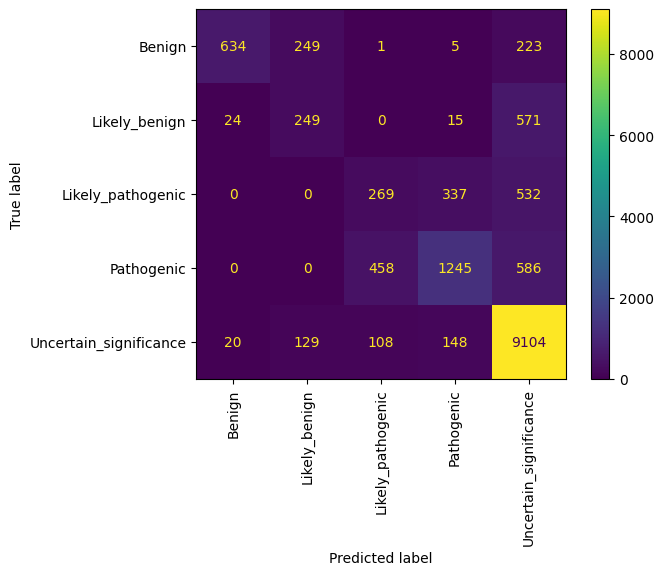

In [97]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')

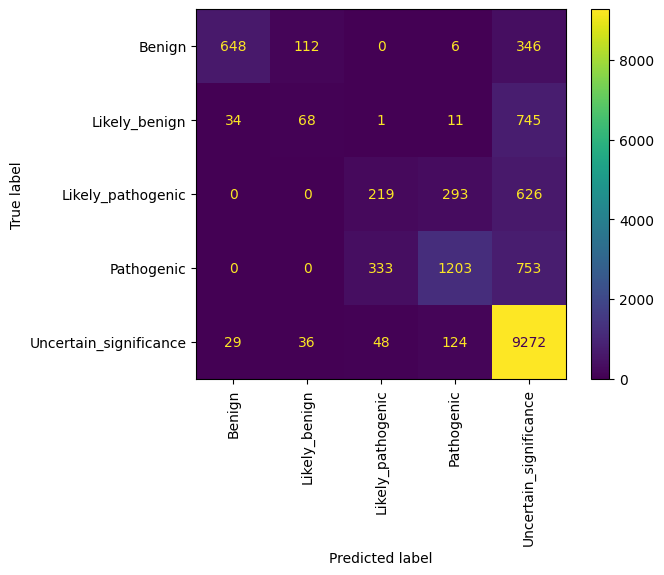

In [98]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')

*Restrizione delle features*

,MetaRNN_score,MetaRNN_rankscore,M-CAP_score,clinvar_review,M-CAP_rankscore,clinvar_id,M-CAP_pred,ClinPred_score,MetaRNN_pred,SIFT_converted_rankscore,...,CADD_phred_hg19,ClinPred_pred,clinvar_trait,REVEL_rankscore,PrimateAI_pred,MetaLR_rankscore,hg18_pos(1-based),clinvar_MedGen_id,VEST4_rankscore,pos(1-based)
0,0.901666,0.89529,0.209438,"criteria_provided,_single_submitter",0.87199,542287,D,0.996178,D,0.91255,...,28.000,D,"Charcot-Marie-Tooth_disease,_axonal,_type_2z",0.95316,D,0.86456,29667444,C4225243,0.99181,30941457
1,0.020408,0.00470,0.071751,"criteria_provided,_multiple_submitters,_no_conflicts",0.71352,39385,D,0.240450,T,0.78490,...,24.500,T,not_provided,0.60717,T,0.89977,40853802,CN517202,0.61172,42127856
2,0.084385,0.14138,0.002825,"criteria_provided,_single_submitter",0.05898,847416,T,0.069487,T,0.31088,...,7.436,T,"Agammaglobulinemia_2,_autosomal_recessive",0.43757,T,0.00929,22252200,C3150750,0.15609,23580013
3,0.381572,0.54233,0.031772,"criteria_provided,_single_submitter",0.53769,216650,D,0.971149,T,0.53900,...,22.700,D,Familial_cancer_of_breast,0.43757,T,0.57468,27437958,C0346153,0.62781,28711970
4,0.438699,0.57961,0.042635,no_assertion_criteria_provided,0.60567,264748,D,0.956455,T,0.59928,...,26.600,D,"Epilepsy,_familial_focal,_with_variable_foci_1",0.48217,T,0.63296,30480963,C4551983,0.74918,31754977
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37838,0.176528,0.32641,0.102584,"criteria_provided,_multiple_submitters,_no_conflicts",0.77614,234069,D,0.754714,T,0.91255,...,22.800,D,Hereditary_cancer-predisposing_syndrome|Familial_cancer_of_breast,0.45348,T,0.93068,27460472,C0027672|C0346153,0.15609,28734484
37839,0.973700,0.97055,0.252742,"criteria_provided,_single_submitter",0.89184,570084,D,0.996013,D,0.91255,...,31.000,D,Familial_cancer_of_breast,0.94913,T,0.84590,27420024,C0346153,0.97426,28694036
37840,0.962804,0.95712,0.078083,"criteria_provided,_single_submitter",0.72922,822448,D,0.991855,D,0.91255,...,32.000,D,Hereditary_cancer-predisposing_syndrome,0.96737,T,0.90294,27435996,C0027672,0.89689,28710008
37841,0.424116,0.57059,0.095228,"criteria_provided,_single_submitter",0.76392,578206,D,0.106996,T,0.58626,...,12.890,T,"Polyarteritis_nodosa,_childhoood-onset",0.69082,T,0.85936,16068144,C3887654,0.40063,17207254


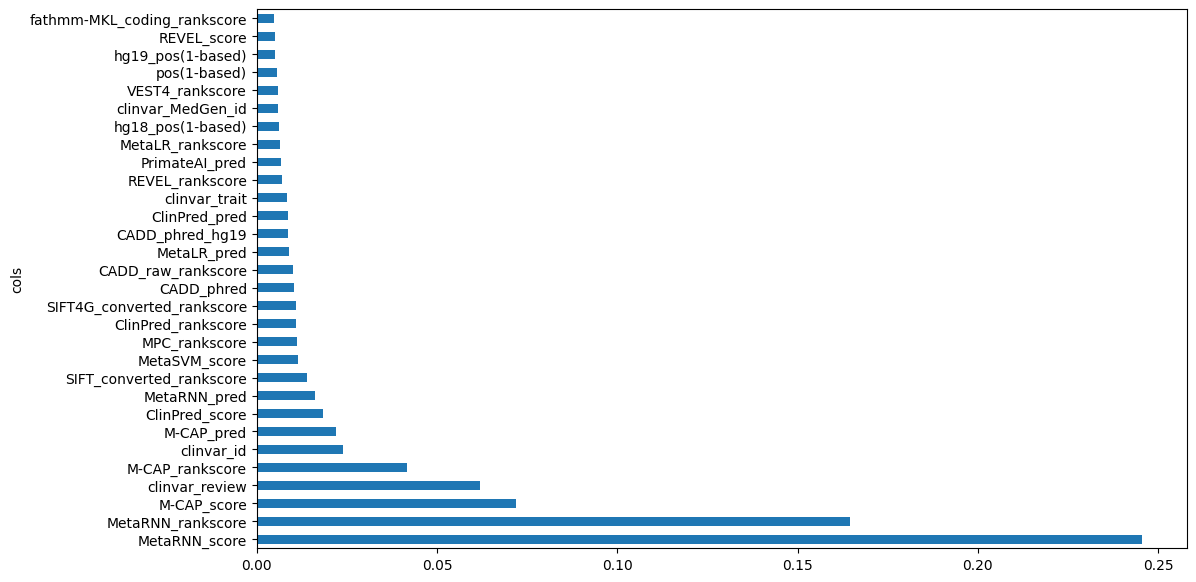

In [99]:
def rf(xs, y, n_estimators=40, max_samples=3328,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

xs,y = to.train.xs,to.train.y
m = rf(xs, y)

def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = rf_feat_importance(m, xs)

def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30])

to_keep = fi[fi.imp>0.005].cols

df_keep = df[to_keep].copy()
df_keep

In [100]:
num_cols = df_keep.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_keep.select_dtypes(include=[object]).columns.tolist()
df = pd.concat([df['clinvar_clnsig'], df_keep], axis=1)
splits = RandomSplitter(valid_pct=0.2, seed=42)(range_of(df))

In [101]:
to = TabularPandas(df, procs=[Categorify, FillMissing],
                   cat_names = cat_cols,
                   cont_names = num_cols,
                   y_names='clinvar_clnsig',
                    y_block=CategoryBlock(),
                   splits=splits)

In [102]:
dls = to.dataloaders(bs=1024)

In [103]:
cols = [col for col in df.columns if col not in test_df.columns]
for col in cols:
    test_df[col] = 0

cols = [col for col in df.columns if col in test_df.columns]
test_df = test_df[cols]

test_df.apply(pd.to_numeric, errors='ignore')
test_df.dropna(axis='rows', how='any', inplace=True, subset=['clinvar_clnsig'])
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'not_provided'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'protective'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_risk_factor'].index, inplace=True)
test_df.drop(axis='index', labels=test_df[test_df.clinvar_clnsig == 'Conflicting_interpretations_of_pathogenicity,_other,_risk_factor'].index, inplace=True)
test_df.replace(to_replace='Conflicting_interpretations_of_pathogenicity', value='Uncertain_significance', inplace=True)
test_df.replace(to_replace='Benign/Likely_benign', value='Benign', inplace=True)
test_df.replace(to_replace='Pathogenic/Likely_pathogenic', value='Pathogenic', inplace=True)
test_df.replace(to_replace=np.nan, value=0, inplace=True)
test_df.reset_index(drop=True, inplace=True)
#test_dl = dls.test_dl(test_df)

*Tabular learner con loss function di raggruppamento*

In [104]:
classes = {0: 1, 1: 1, 2: 2, 3: 2, 4: 3}

class GroupLoss(nn.Module):
    def __init__(self, gamma = 2.0):
        super(GroupLoss, self).__init__()
        self.gamma = gamma

    def forward(self, inp, targ):
        sm_acts = torch.softmax(inp, dim=1)
        losses = []
        for i in range(len(targ)):
            target_class = classes[targ[i].item()]
            pred_class = sm_acts[i].argmax().item()
            if target_class != classes[pred_class]:
                losses.append(torch.pow(1 - sm_acts[i][targ[i].item()], self.gamma) * torch.log(sm_acts[i][targ[i].item()]) * 3)
            else:
                losses.append(torch.pow(1 - sm_acts[i][targ[i].item()], self.gamma) * torch.log(sm_acts[i][targ[i].item()]))
      
        return -torch.stack(losses).mean()

In [105]:
def accuracy_pen(input, target):
    sm_acts = torch.softmax(input, dim=1),
    preds = sm_acts.argmax(dim=1),
    preds_class = [classes[pred.item()] for pred in preds],
    targ_class = [classes[t.item()] for t in target],
    return (torch.tensor(preds_class) == torch.tensor(targ_class)).float().mean()

In [134]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=GroupLoss(gamma=6))

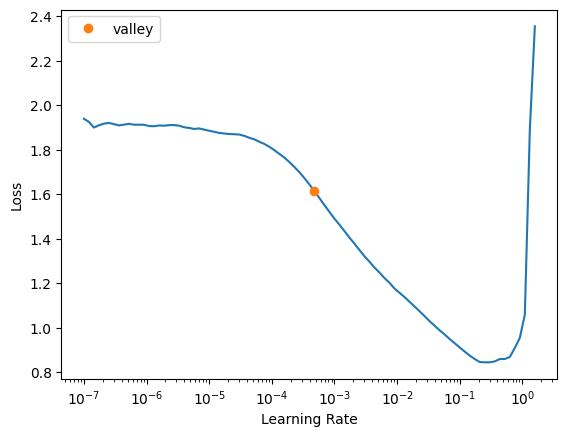

In [107]:
torch.cuda.empty_cache()
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.432131,0.309218,0.784223,00:04
1,0.308484,0.221800,0.885571,00:04
2,0.229108,0.130264,0.902220,00:04
3,0.160336,0.084946,0.912394,00:04
4,0.112034,0.058698,0.908562,00:04
5,0.078682,0.045457,0.919265,00:04
6,0.056541,0.041583,0.928515,00:04
7,0.042042,0.031574,0.935254,00:04
8,0.032726,0.029705,0.932479,00:04
9,0.025427,0.027526,0.939086,00:04


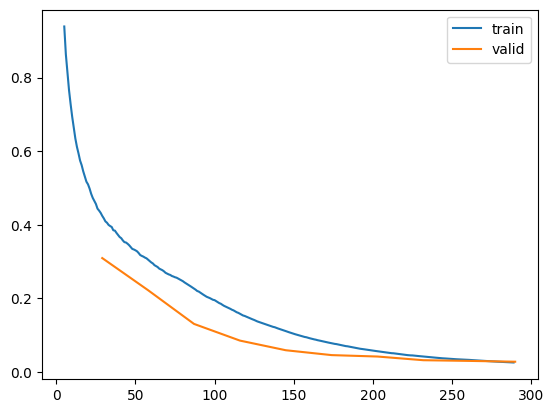

In [135]:
learn.fit(10, lr, 1e-3)
learn.recorder.plot_loss()

In [137]:
test_dl = dls.test_dl(test_df)
learn.validate(dl=test_dl)

(#2) [0.33801817893981934,0.7536727786064148]

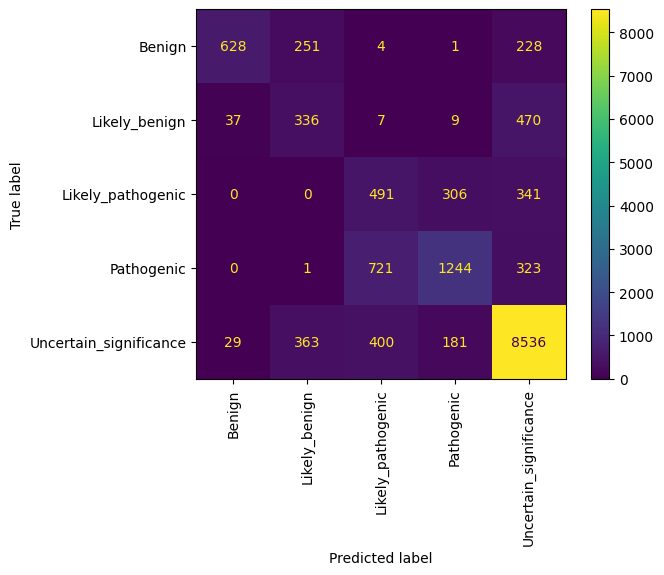

In [138]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds, targets = learn.get_preds(dl=test_dl)
pred_classes = np.argmax(preds, axis=1)

# Flattening delle etichette di classe
true_classes = targets.squeeze().numpy()

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dls.vocab)
disp.plot(xticks_rotation='vertical')

*Tabular learner standard*

In [130]:
learn = tabular_learner(dls, metrics=accuracy, loss_func=FocalLossFlat(gamma=7))

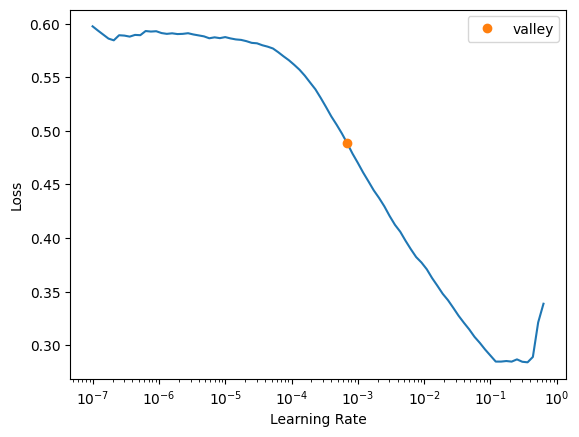

In [118]:
lr = learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,0.147505,0.227830,0.672172,00:00
1,0.107762,0.086473,0.885571,00:00
2,0.080074,0.046370,0.905391,00:00
3,0.056180,0.028879,0.919001,00:00
4,0.038598,0.020268,0.925872,00:00
5,0.026599,0.013958,0.931818,00:00
6,0.018677,0.011896,0.934593,00:00
7,0.013739,0.010398,0.934197,00:00
8,0.010417,0.009590,0.943314,00:00
9,0.008105,0.009310,0.944107,00:00


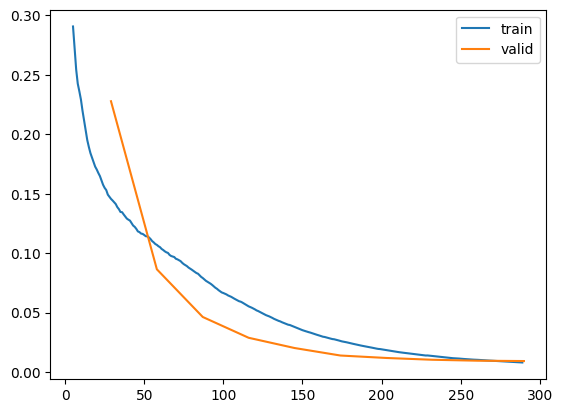

In [131]:
learn.fit(10, lr, wd=0.01)
learn.recorder.plot_loss()

In [132]:
test_dl = dls.test_dl(test_df)
learn.validate(dl=test_dl)

(#2) [0.11720193177461624,0.7495136260986328]

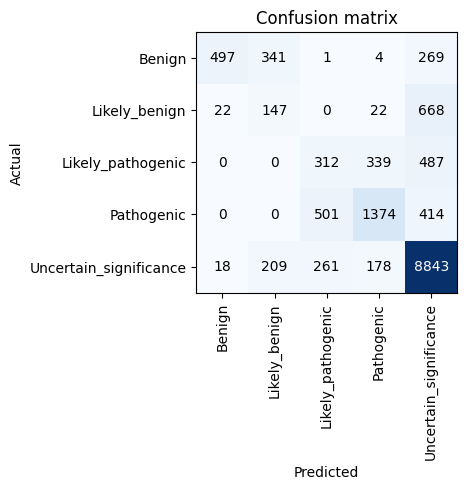

In [133]:
interp = ClassificationInterpretation.from_learner(learn, dl=test_dl)
interp.plot_confusion_matrix()